In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

We will use Diabetes dataset from scikit-learn (version '1.0.2') to demonstrate the Coefficient Magnitude method for explianing a Linear Regression model.

The "Diabetes" dataset contains ten baseline variables (such as age, BMI, blood pressure, etc.) for a set of diabetes patients and a target variable (a quantitative measure of disease progression one year after baseline). 

Here are feature description:

* age: age in years
* sex
* bmi: body mass index
* bp: average blood pressure
* s1: tc, total serum cholesterol
* s2: ldl, low-density lipoproteins
* s3: hdl, high-density lipoproteins
* s4: tch, total cholesterol / HDL
* s5: ltg, possibly log of serum triglycerides level
* s6: glu, blood sugar level

The aim is to use these features to predict a quantitative measure of disease progression one year after baseline.

We first load the "Diabetes" dataset:

In [2]:
random_state = 42

# Load the Diabetes dataset
diabetes_data = load_diabetes()
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = diabetes_data.target

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)


Standardizing features is a best practice when using linear models, as it ensures that each feature contributes equally to the model's predictions and prevents any feature from dominating the others due to its scale.

**Food for Thought**: How standardization does facilitate the explanation of linear models? Dose it make sense to standardize binary features (such as sex in this case)?

In [3]:
# Standardizing features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


# Create and fit the Random Forest Regressor model
model = LinearRegression()
model.fit(X_train_standardized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_standardized)

Evaluating the performance of the regression model is crucial to understand how well it fits the data. One common way to assess the model's goodness of fit is by using an R-squared plot. The R-squared (coefficient of determination) measures the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R-squared value indicates a better fit of the model to the data.

In [4]:
# Calculate R-squared value
r2 = r2_score(y_test, y_pred)

In [5]:
# Retrieve the coefficients and feature names
coefficients = model.coef_
feature_names = diabetes_data.feature_names

# Create a DataFrame to store the coefficients with their corresponding feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by coefficient magnitude in descending order
coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index)


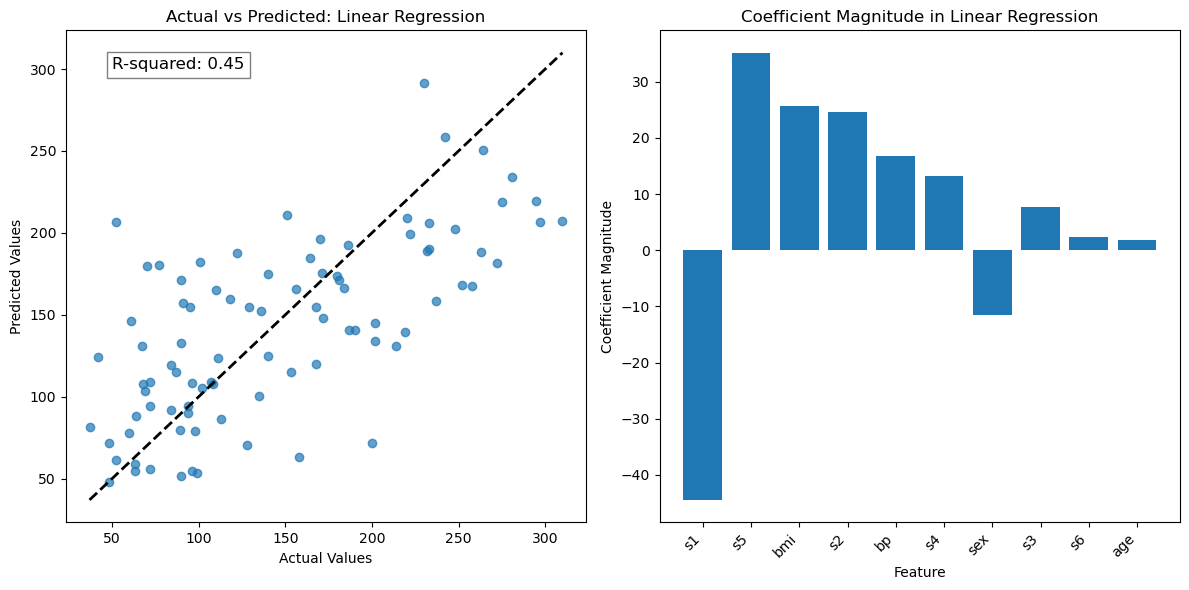

In [6]:
# Create an Actual vs Predicted scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted: Linear Regression')
plt.text(50, 300, f'R-squared: {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)


# Create a bar plot to visualize coefficient magnitudes
plt.subplot(1, 2, 2)
plt.bar(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Coefficient Magnitude')
plt.title('Coefficient Magnitude in Linear Regression')
plt.tight_layout()
plt.show()

we create an Actual vs Predicted scatter plot to visualize the model's performance. The scatter plot displays the actual target values on the x-axis and the corresponding predicted values on the y-axis. The diagonal dashed line represents perfect predictions, where the actual and predicted values would be identical.

The bar plot will now display the feature importance based on the standardized coefficient magnitudes for the "Diabetes" dataset. The standardized coefficients allow us to directly compare the relative importance of features, even when they are on different scales.

Again, please note that the Coefficient Magnitude method is specific to linear models like Linear Regression.

## From Coefficient Magnitudes to Feature Importance

To move one step further in more robust interpretation of a linear model, we can transform the coefficient magnitude into feature importance by deviding the individual coefiicients by their standard deviation. To calculated the standard deviation of coefficients we need to use a bag of Linear Regression models:

In [7]:
from sklearn.ensemble import BaggingRegressor

random_state = 42

# Creating, estimating, and predicting using a bag of 100 Linear regressor models.
n_estimators = 100

# mind that in the newer sklearn versions (the latest) the first input is called 'estimator' instead of 'base_estimator'
bagged_model = BaggingRegressor(estimator=LinearRegression(), 
                                n_estimators=n_estimators, 
                                random_state=random_state)
bagged_model.fit(X_train_standardized, y_train)

y_pred = bagged_model.predict(X_test_standardized)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)


Now, we can retrieve the weights of every single model in our bag and use the following formula to convert the coefficient magnitude $\beta$ for the $j$ th feature into feature importances: $\frac{\bar{\beta}_j}{SE(\beta_j)}$

In [8]:
coefficients = []
for i in range(n_estimators):
    coefficients.append(bagged_model.estimators_[i].coef_)
coefficients = np.vstack(coefficients)

feature_importance = np.mean(coefficients, axis=0) / (np.std(coefficients, axis=0)/n_estimators**0.5)
     # Group edit > Note that the expression for the feature importance is equivalent to a t test statistic
     # where the hypothesis being tested is that the feature has a theoretical mean of 0. Standard Error 
     # is calculated as the expected deviation going by the average variance, so taking the square root of 
     # the average variance give you standard error. 

# Create a DataFrame to store the feature importance with their corresponding feature names
fi_df = pd.DataFrame({'Feature': feature_names, 't_stats': feature_importance})

# Sort the DataFrame of feature importance in descending order
fi_df = fi_df.reindex(fi_df['t_stats'].abs().sort_values(ascending=False).index)

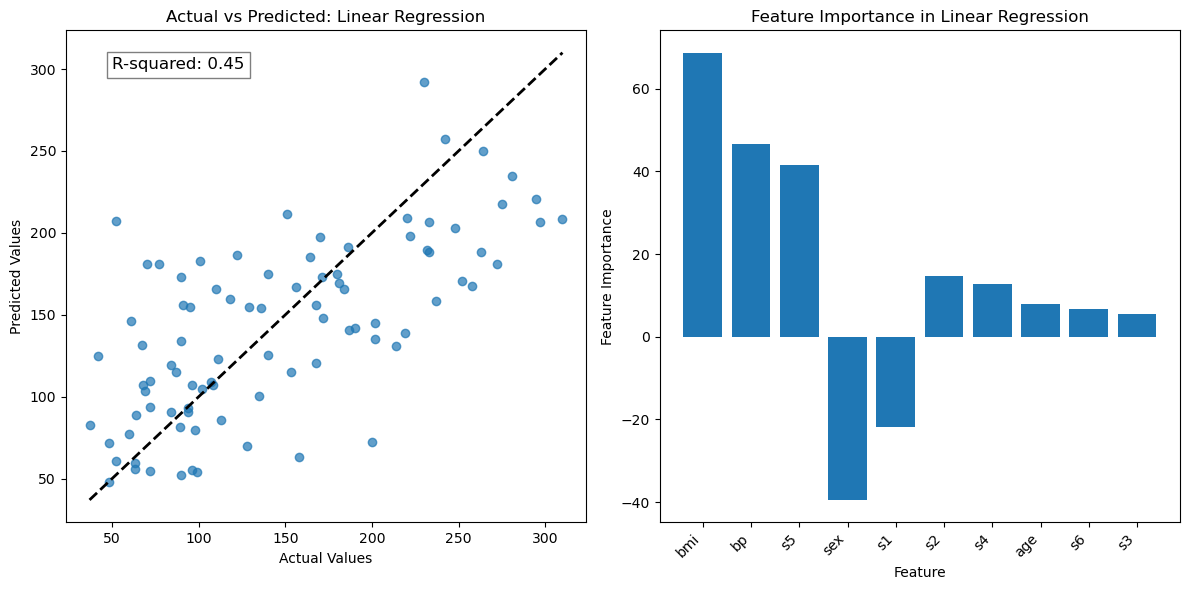

In [9]:
# Create an Actual vs Predicted scatter plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted: Linear Regression')
plt.text(50, 300, f'R-squared: {r2:.2f}', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)


# Create a bar plot to visualize feature importances
plt.subplot(1, 2, 2)
plt.bar(fi_df['Feature'], fi_df['t_stats'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Linear Regression')
plt.tight_layout()
plt.show()

**Exercise 1:** Compare the interpretation results for coefficient magnitude and feature importance methods. How do you describe the diffference between the two?  

**Exercise 2:** Evaluate the satisfaction of homoscedasticity and multi-collinearity assumtions in this example. You can plot (use scatter plot) the error (y-axis) with respect to different features (x-axis) to evaluate the homoscedasticity assumption (the distribution of error aound zero should be normal). To check for multi-collinearity, you can plot heatmap of correlation between features.  

#### Exercise 1

In [10]:
# making a dataframe of average coefficients for the bagged model for adequate comparison
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': np.mean(coefficients, axis=0)}) 
coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

A difference between the two is that . . . 


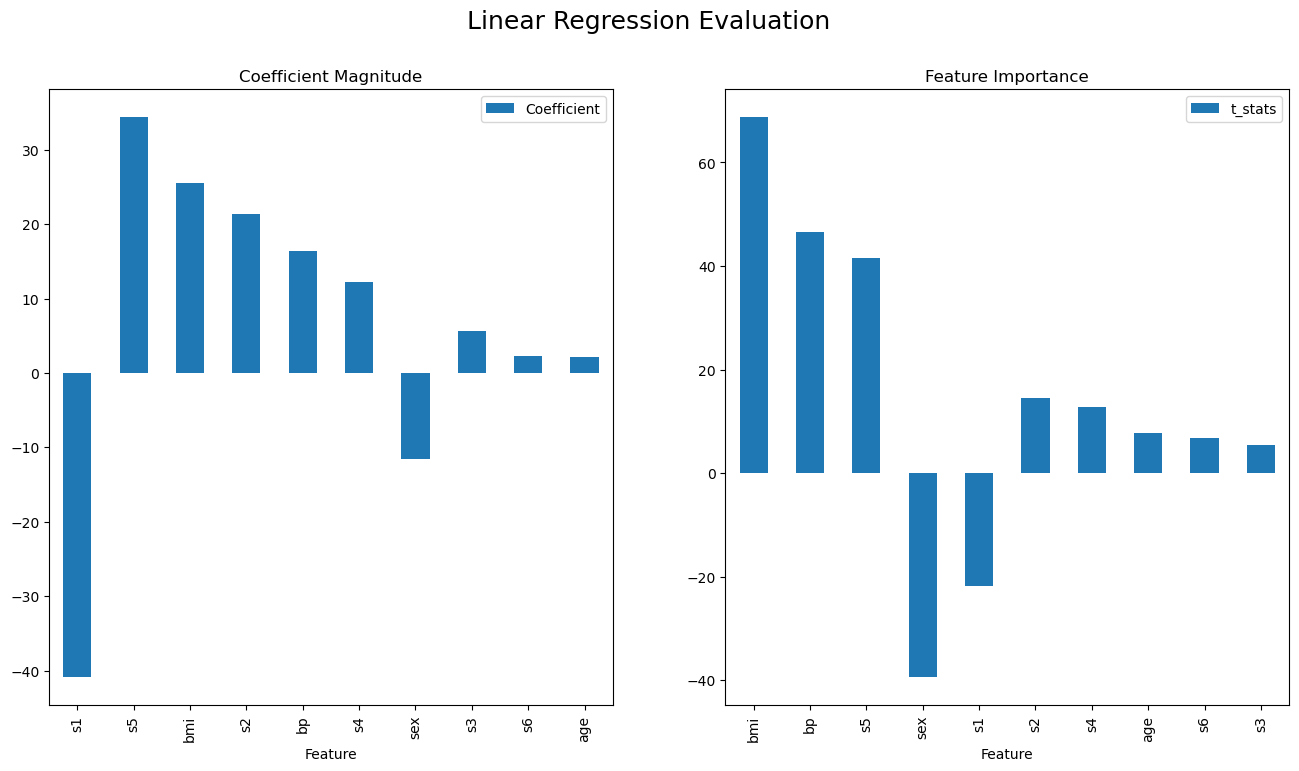

In [11]:
fig1, axes1 = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
fi_df.set_index("Feature").plot(kind="bar", ax=axes1[1]) 
coeff_df.set_index("Feature").plot(kind="bar", ax=axes1[0]) 
axes1[0].set_title('Coefficient Magnitude') 
axes1[1].set_title('Feature Importance') 
fig1.suptitle('Linear Regression Evaluation', fontsize=18) 
;  
# Implication of standardization 
# conclusions of fi_df from plot 
# conclusions of coeff_df from plot 
# quantitative comparisson of plots  (difference in places from factor to factor 
# qualitative comparisson of plots
print("A difference between the two is that . . . ")

#### Exercise 2.1

In [24]:
residuals_train = bagged_model.predict(X_train) - y_train
residuals_test = bagged_model.predict(X_test) - y_test  

C:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(
C:\Users\diego\anaconda3\lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but BaggingRegressor was fitted without feature names
  warnings.warn(


C:\Users\diego\AppData\Local\Temp\ipykernel_39512\2872063016.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Data = X_train.append(X_test)


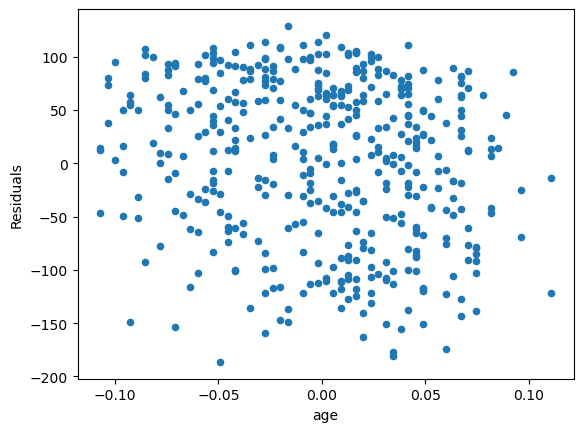

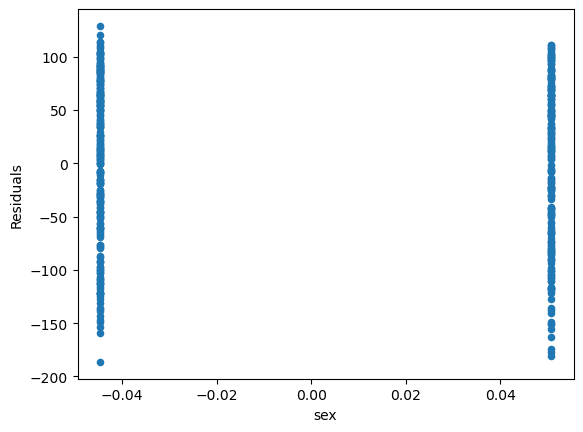

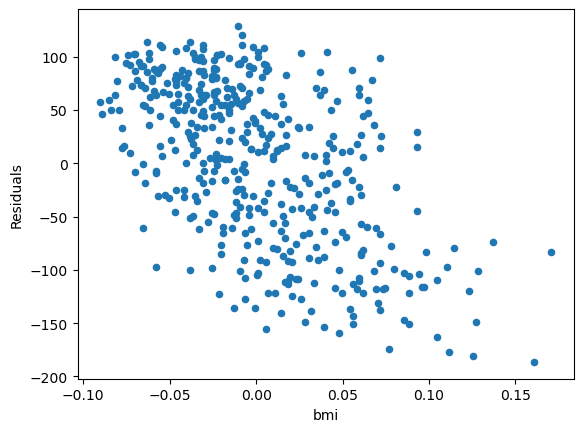

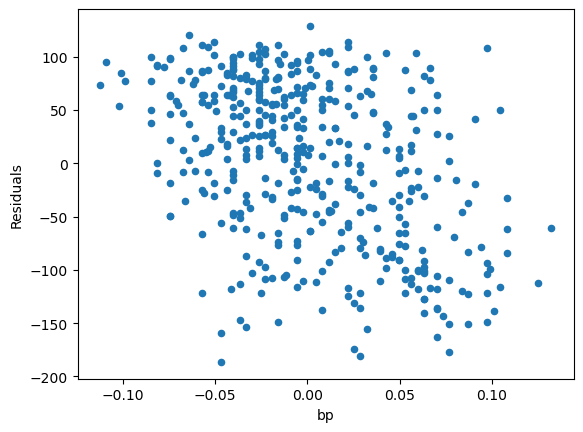

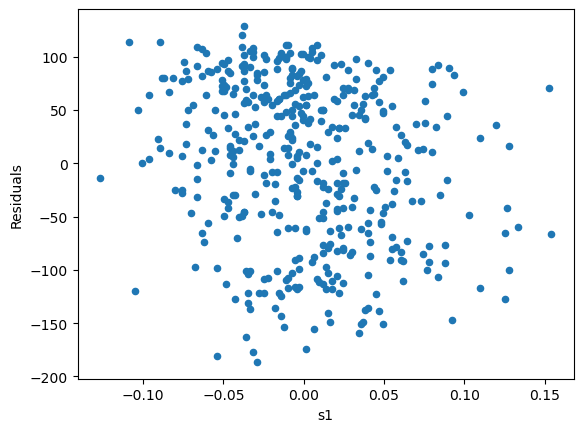

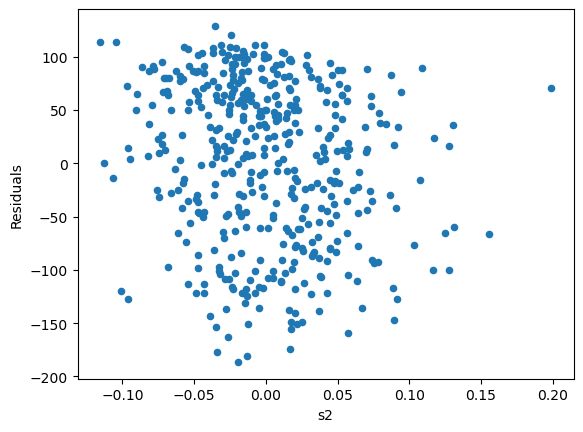

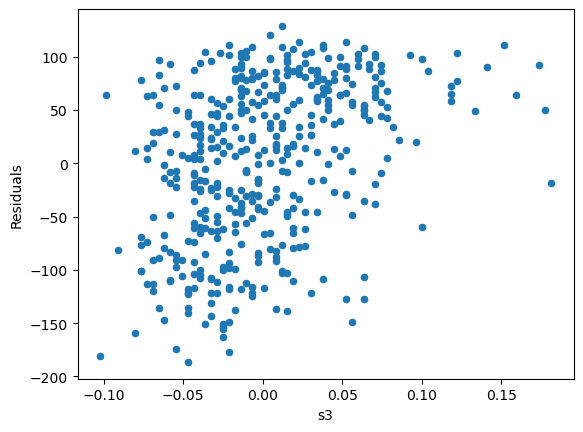

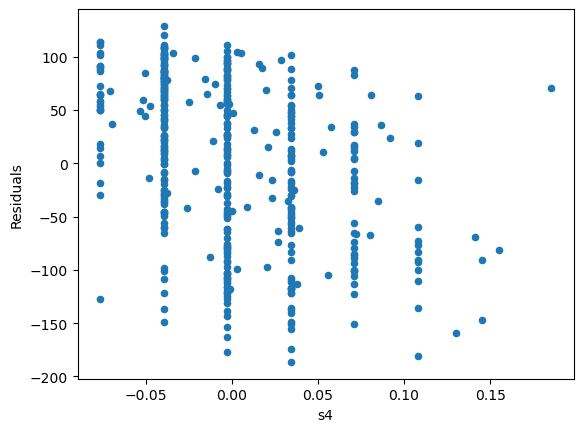

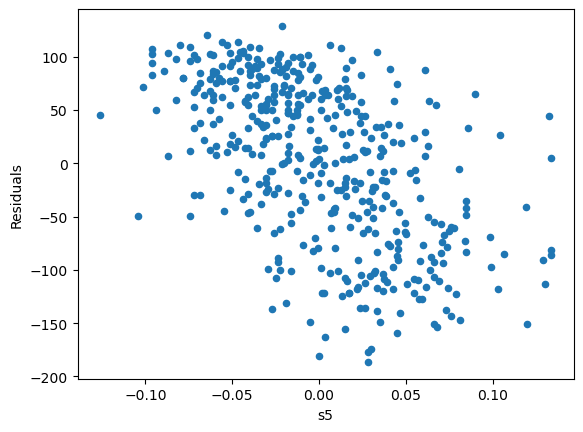

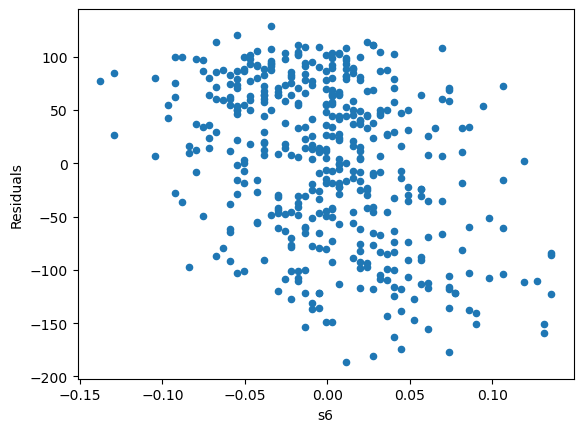

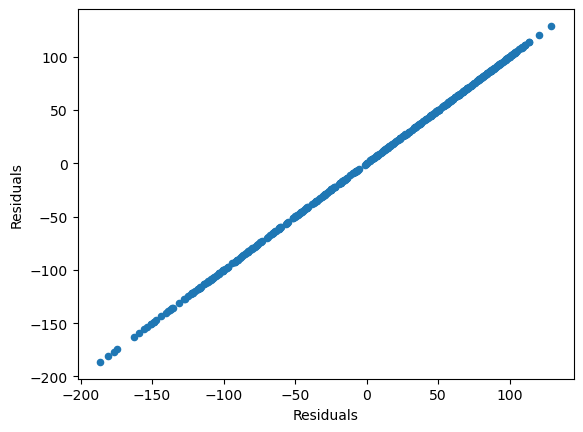

In [35]:
X_train['Residuals'] = residuals_train 
X_test['Residuals'] = residuals_test 
Data = X_train.append(X_test) 
for feature in Data.columns[:]:  
    Data.plot(kind='scatter', x=feature, y='Residuals')
print('The distribution of residuals with respect to feature\'s is ge'   

#### Exercise 2.2

C:\Users\diego\AppData\Local\Temp\ipykernel_39512\3557752258.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sns.heatmap(X_train.append(X_test).corr())


There is no perfect multicollinearity between different pairs of features. This is indicated by no squares outside of the diagonal matching colors with the diagonal color, which would indicate perfect multicollinearity. Another indication is that -1 is not in the range of the correlations calculated.




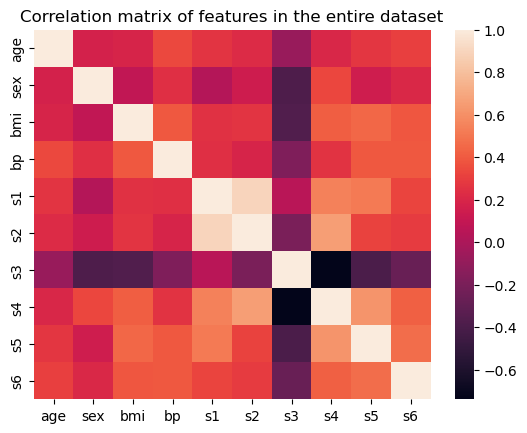

In [21]:
import seaborn as sns
sns.heatmap(X_train.append(X_test).corr())  
plt.title('Correlation matrix of features in the entire dataset')
;  
print('There is no perfect multicollinearity between different pairs of features. This is indicated by no squares outside of the diagonal matching colors with the diagonal color, which would indicate perfect multicollinearity. Another indication is that -1 is not in the range of the correlations calculated.')
print()
print()